In [1]:
import os
import pandas as pd
from sympy import symbols, Eq, solve
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
import seaborn as sns
from matplotlib.collections import PathCollection

params_dict = {
    'font.size' : 12,
    'axes.labelsize': 'medium',
    'xtick.top' : True,
    'ytick.right' : True,
    'axes.labelsize' : 16,
    'xtick.labelsize' : 14,
    'ytick.labelsize' : 14,
    'xtick.top' : True,
    'ytick.right' : True,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    'legend.frameon' : True,
    'svg.fonttype' : 'none',
    'pdf.fonttype' : 42,
    'savefig.transparent' : True
}
plt.rcParams.update(params_dict)
save_dir = os.path.join(os.getcwd(), 'figs_python')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
print(f' Figures will be saved in this folder:\n {save_dir}')

 Figures will be saved in this folder:
 \\cifs1.bpcentral.biophys.mpg.de\msdata\kimlab\SMC56LoopingProject\Manuscript\Nature\ResearchData\figs_python


In [2]:
# Common functions
def error_calc(values, total, norm=100):
    if type(total) == list:
        total = np.array(total)
    else:
        total = np.array([total])
    values_arr = np.array(values).astype(int)
    fractions = values_arr/total
    fractions = norm*values_arr/total
    fractions_err = norm * (1/total) * np.sqrt(total * fractions * (1 - fractions))
    # p_values = stats.binomtest(values_arr[0], total[0], fractions[0]/norm)
    # print(f'p_values: {p_values}')
    return fractions, fractions_err

def barstat_err_plot(labels, values, total,
            ax=None, width = 0.2, shift=0, norm=1, label='Fractions'):
    '''
    labels and values as list of same length
    total: total events
    '''
    x_ticks = 0.25*np.arange(1, 1+len(labels))
    fractions, fractions_err = error_calc(values, total, norm=norm)
    print(f'error: {fractions_err}')
    # fractions = norm * fractions # convert into percentage
    # fractions_err = norm * fractions_err
    if ax is None:
        fig, ax = plt.subplots(figsize=(3,4))
    ax.bar(x_ticks+shift, fractions, width,alpha=0.8, label=label)
    ax.errorbar(x_ticks+shift, fractions, yerr=fractions_err, fmt='*', capsize=5, ecolor='k', mfc='k', label='')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(labels, fontsize=12)
    # ax.set_ylim(0, 100)
    ax.set_ylabel('fractions (%)')
    ax.legend()
    return ax

In [3]:
excel_path_new = 'HexamerVsWildtypeNew.xlsx'
excel_all_data_label = pd.ExcelFile(excel_path_new)
print('HexamerVsWildtypeNew.xlsx :', excel_all_data_label.sheet_names)
excel_all_data_label.close()

HexamerVsWildtypeNew.xlsx : ['HexNse4Al647_KGlu', 'HexNse4Al647_NaCl', 'OctNse2Al647_KGlu', 'Nse2Al647HighSalt', 'HexNse4Al647HighSalt', 'Nse56flow', 'HexNse4Al647_NaCl (dna)', 'OctNse4Al647_NaCl (dna)', 'OctNse4Al647_KGlu (dna)']


In [4]:
df_octamer_dna = pd.read_excel(excel_path_new, sheet_name='OctNse4Al647_NaCl (dna)')
df_hexamer_dna = pd.read_excel(excel_path_new, sheet_name='HexNse4Al647_NaCl (dna)')
df_hexamer_new = pd.read_excel(excel_path_new, sheet_name='HexNse4Al647_NaCl')
df_octamer_dna.head()

,Name,#binding,#looping,#bindingInLoop,co-localization protein and loop start?,bleaching?,Looping at Start?,loopingAtDnaEnd?,#BleachingStepLooping,translocation,region,Comments,folderpath
0,dna,1.0,0.0,0.0,no,no,no,no,0.0,1.0,NaN,NaN,20220817_CH1_2nMOctamerNse4SnapAl647_imgs_2_an...
1,dna (2),2.0,0.0,0.0,no,no,no,no,0.0,2.0,NaN,NaN,20220817_CH1_2nMOctamerNse4SnapAl647_imgs_2_an...
2,dna (3),0.0,0.0,0.0,no,no,no,no,0.0,0.0,NaN,NaN,20220817_CH1_2nMOctamerNse4SnapAl647_imgs_2_an...
3,dna (4),0.0,0.0,0.0,no,no,no,no,0.0,0.0,NaN,NaN,20220817_CH1_2nMOctamerNse4SnapAl647_imgs_2_an...
4,dna (5),0.0,0.0,0.0,no,no,no,no,0.0,0.0,NaN,NaN,20220817_CH1_2nMOctamerNse4SnapAl647_imgs_2_an...


In [5]:
df_hexamer = df_hexamer_dna.copy()
df_octamer = df_octamer_dna.copy()


## Octamer vs Hexamer

total number of octamer events 159
Octamer binding: 57.0, looping: 7, translocating: 49.0
total number of hexamer events 135
Hexamer binding: 102.0, looping: 92.0, translocating: 16.0
error: [0.03803136 0.01626953 0.03661834]
error: [0.03698762 0.04009844 0.02781844]


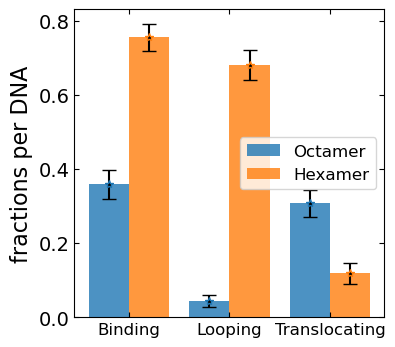

In [6]:
# Cleanup dataframe
def calc_oct_hex_binding(df_hexamer, df_octamer, plotting=True, norm_to_1 = True):
    norm_factor = 1#.25 #(equivalant concentration as 2nM hexamer)
    oct_binding = df_octamer['#binding'].sum() / norm_factor
    oct_binding_inLoop = df_octamer['#bindingInLoop'].sum()
    oct_binding = oct_binding - oct_binding_inLoop
    oct_looping = df_octamer['#looping'].sum() / norm_factor
    oct_looping = len(df_octamer[df_octamer['co-localization protein and loop start?']=='yes'])
    oct_translocating = oct_binding - oct_looping
    oct_translocating = df_octamer['translocation'].sum() / norm_factor
    oct_num_dna = len(df_octamer)

    hex_binding = df_hexamer['#binding'].sum()
    hex_binding_inLoop = df_hexamer['#bindingInLoop'].sum()
    hex_binding = hex_binding - hex_binding_inLoop
    hex_looping = df_hexamer['#looping'].sum()
    hex_looping = len(df_hexamer[df_hexamer['co-localization protein and loop start?']=='yes'])
    hex_translocating = hex_binding - hex_looping
    hex_num_dna = len(df_hexamer)

    nse2_binding = df_hexamer['#binding'].sum()
    hex_binding_inLoop = df_hexamer['#bindingInLoop'].sum()
    # hex_binding = hex_binding - hex_binding_inLoop
    hex_looping = df_hexamer['#looping'].sum()
    hex_translocating = hex_binding - hex_looping
    hex_translocating = df_hexamer['translocation'].sum()
    hex_num_dna = len(df_hexamer)


    labels = ['Binding', 'Looping', 'Translocating']

    values_oct = [oct_binding, oct_looping, oct_translocating]
    total_oct = oct_num_dna
    if norm_to_1:
        total_oct = oct_looping + oct_translocating
    print(f'total number of octamer events {total_oct}')
    print(f'Octamer binding: {oct_binding}, looping: {oct_looping}, translocating: {oct_translocating}')

    values_hex = [hex_binding, hex_looping, hex_translocating]
    total_hex = hex_num_dna
    if norm_to_1:
        total_hex = hex_looping + hex_translocating
    print(f'total number of hexamer events {total_hex}')
    print(f'Hexamer binding: {hex_binding}, looping: {hex_looping}, translocating: {hex_translocating}')
    if plotting:
        fig, ax = plt.subplots(figsize=(4,4))
        ax = barstat_err_plot(labels, values_oct, total_oct, ax=ax, width=0.1, shift=-0.1/2, norm=1, label='Octamer')
        ax = barstat_err_plot(labels, values_hex, total_hex, ax=ax, width=0.1, shift=+0.1/2, norm=1, label='Hexamer')
        ax.set_ylabel('fractions per DNA')
    results = {
        'labels': labels,
        'values_oct' : values_oct,
        'oct_binding': oct_binding,
        'oct_num_dna': oct_num_dna,
        'total_oct': total_oct,
        'values_hex': values_hex,
        'hex_binding': hex_binding,
        'hex_num_dna' : hex_num_dna,
        'total_hex': total_hex,
    }
    return results


results = calc_oct_hex_binding(df_hexamer, df_octamer, plotting=True, norm_to_1=False)
plt.savefig(os.path.join(save_dir, 'fractions_loading_OctamerNse4_Vs_HexamerNse4.svg'))


total_oct: [159], total_hex: 135


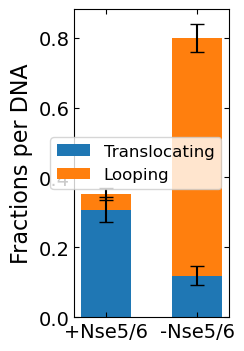

In [7]:
fractions_oct, fractions_err_oct = error_calc(results['values_oct'], results['total_oct'], norm=1)
fractions_hex, fractions_err_hex = error_calc(results['values_hex'], results['total_hex'], norm=1)
loop_bar = [fractions_oct[1], fractions_hex[1]]
loop_err = [fractions_err_oct[1], fractions_err_hex[1]]
label_bar = ['+Nse5/6', '-Nse5/6']
fig, ax = plt.subplots(figsize=(2,4))
width = 0.55

trans_bar = [fractions_oct[2], fractions_hex[2]]
trans_err = [fractions_err_oct[2], fractions_err_hex[2]]
ax.bar(label_bar, trans_bar, width, yerr=trans_err, capsize=5,
       # bottom=loop_bar,
       label='Translocating')
ax.bar(label_bar, loop_bar, width, yerr=loop_err, capsize=5,
       bottom=trans_bar,
       label='Looping')

ax.set_ylabel('Fractions per DNA')
ax.legend()
plt.savefig(os.path.join(save_dir, 'fractions_loading_OctamerNse4_Vs_HexamerNse4_stackedBar.svg'))

total_oct = results['total_oct']
total_hex = results['total_hex']
print(f'total_oct: {[total_oct]}, total_hex: {total_hex}')

### std across multiple days

total number of octamer events 18.0
Octamer binding: 20.0, looping: 3, translocating: 15.0
total number of hexamer events 33.0
Hexamer binding: 29.0, looping: 28.0, translocating: 5.0
total number of octamer events 17.0
Octamer binding: 15.0, looping: 3, translocating: 14.0
total number of hexamer events 19.0
Hexamer binding: 19.0, looping: 16.0, translocating: 3.0
total number of octamer events 21.0
Octamer binding: 22.0, looping: 1, translocating: 20.0
total number of hexamer events 17.0
Hexamer binding: 16.0, looping: 13.0, translocating: 4.0


C:\Users\bipradha\AppData\Local\Temp\ipykernel_7392\4282928394.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_octamer = df_octamer_dna[df_octamer_dna['folderpath'].str.contains(f'({strg})')]
C:\Users\bipradha\AppData\Local\Temp\ipykernel_7392\4282928394.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_hexamer = df_hexamer_dna[df_hexamer_dna['folderpath'].str.contains(f'({strg})')]
C:\Users\bipradha\AppData\Local\Temp\ipykernel_7392\2694886906.py:10: RuntimeWarning: invalid value encountered in sqrt
  fractions_err = norm * (1/total) * np.sqrt(total * fractions * (1 - fractions))


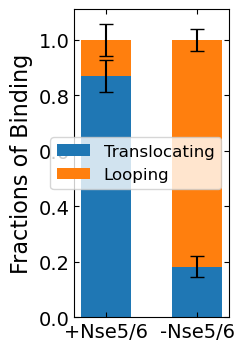

In [8]:
strngs = ['20220817_CH1','20221221_CH1','20221221_CH2']
fractions_oct_loop_list = []
# fractions_err_oct_loop_list = []
fractions_hex_loop_list = []
# fractions_err_hex_loop_list = []
fractions_oct_trans_list = []
# fractions_err_oct_trans_list = []
fractions_hex_trans_list = []
# fractions_err_hex_trans_list = []
binding_oct_list = []
total_binding_oct_list = []
binding_hex_list = []
total_binding_hex_list = []

for strg in strngs:
    df_octamer_dna = df_octamer_dna[df_octamer_dna['folderpath'].notna()]
    df_octamer = df_octamer_dna[df_octamer_dna['folderpath'].str.contains(f'({strg})')]

    df_hexamer_dna = df_hexamer_dna[df_hexamer_dna['folderpath'].notna()]
    df_hexamer = df_hexamer_dna[df_hexamer_dna['folderpath'].str.contains(f'({strg})')]
    results = calc_oct_hex_binding(df_hexamer, df_octamer, plotting=False)
    fractions_oct, fractions_err_oct = error_calc(results['values_oct'], results['total_oct'], norm=1)
    fractions_hex, fractions_err_hex = error_calc(results['values_hex'], results['total_hex'], norm=1)
    fractions_oct_loop_list.append(fractions_oct[1])
    fractions_oct_trans_list.append(fractions_oct[2])
    fractions_hex_loop_list.append(fractions_hex[1])
    fractions_hex_trans_list.append(fractions_hex[2])
    binding_oct_list.append(results['oct_binding'])
    total_binding_oct_list.append(results['oct_binding']/results['oct_num_dna'])
    binding_hex_list.append(results['hex_binding'])
    total_binding_hex_list.append(results['hex_binding']/results['hex_num_dna'])

loop_bar = [np.array(fractions_oct_loop_list).mean(), np.array(fractions_hex_loop_list).mean()]
loop_err = [np.array(fractions_oct_loop_list).std(), np.array(fractions_hex_loop_list).std()]
trans_bar = [np.array(fractions_oct_trans_list).mean(), np.array(fractions_hex_trans_list).mean()]
trans_err = [np.array(fractions_oct_trans_list).std(), np.array(fractions_hex_trans_list).std()]

label_bar = ['+Nse5/6', '-Nse5/6']
fig, ax = plt.subplots(figsize=(2,4))
width = 0.55
ax.bar(label_bar, trans_bar, width, yerr=trans_err, capsize=5,
       # bottom=loop_bar,
       label='Translocating')
ax.bar(label_bar, loop_bar, width, yerr=loop_err, capsize=5,
       bottom=trans_bar,
       label='Looping')
ax.set_ylabel('Fractions of Binding')
ax.legend()
plt.savefig(os.path.join(save_dir, 'fractions_loading_OctamerNse4_Vs_HexamerNse4_stackedBar_diffExpts.svg'))


In [9]:
print(loop_bar, (loop_bar[0] - loop_bar[1])/loop_bar[0])
print(loop_err, (loop_err[0] - loop_err[1])/loop_err[0])

print(trans_bar, (trans_bar[0] - trans_bar[1])/trans_bar[0])
print(trans_err, (trans_err[0] - trans_err[1])/trans_err[0])

print(total_binding_hex_list)
print(total_binding_oct_list)

[0.13025210084033614, 0.8184319979985615] -5.283445662053472
[0.058567313597461944, 0.03807927173682901] 0.3498204135065672
[0.8697478991596638, 0.18156800200143852] 0.79124065470366
[0.05856731359746191, 0.03807927173682899] 0.3498204135065671
[0.90625, 0.48717948717948717, 0.5333333333333333]
[0.6060606060606061, 0.32608695652173914, 0.3013698630136986]


[0.4111724751986812, 0.6422542735042734] 0.35979799253769335
[0.13817566438176285, 0.18762169754535865]


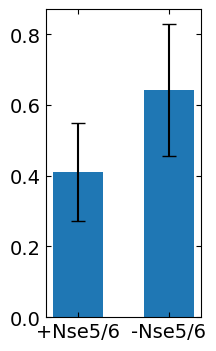

In [10]:
label_bar = ['+Nse5/6', '-Nse5/6']
fig, ax = plt.subplots(figsize=(2,4))
width = 0.55
total_bar = [np.array(total_binding_oct_list).mean(), np.array(total_binding_hex_list).mean()]
total_err = [np.array(total_binding_oct_list).std(), np.array(total_binding_hex_list).std()]
ax.bar(label_bar, total_bar, width, yerr=total_err, capsize=5,
       # bottom=loop_bar,
       label='Translocating')
plt.savefig(os.path.join(save_dir, 'fractions_binding_OctamerNse4_Vs_HexamerNse4_diffExpts.svg'))

print(total_bar, (total_bar[1] - total_bar[0])/total_bar[1])
print(total_err)


In [11]:
print(len(df_hexamer["#binding"]), len(df_octamer["#binding"]))
stats.ttest_ind(df_hexamer["#binding"], df_octamer["#binding"])


30 73


Ttest_indResult(statistic=2.1720872202980184, pvalue=0.03218902771553432)

### NaCl Vs KGlu bidning

C:\Users\bipradha\AppData\Local\Temp\ipykernel_7392\109217879.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_octamer = df_octamer_dna[df_octamer_dna['folderpath'].str.contains(f'(20221221)')]
C:\Users\bipradha\AppData\Local\Temp\ipykernel_7392\109217879.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_octamer_glu = df_octamer_dna_kglu[df_octamer_dna_kglu['folderpath'].str.contains(f'(20221221)')]
C:\Users\bipradha\AppData\Local\Temp\ipykernel_7392\2694886906.py:10: RuntimeWarning: invalid value encountered in sqrt
  fractions_err = norm * (1/total) * np.sqrt(total * fractions * (1 - fractions))


total number of octamer events 119
Octamer binding: 37.0, looping: 4, translocating: 34.0
total number of hexamer events 32
Hexamer binding: 105, looping: 2, translocating: 96
error: [0.0424314  0.01652184 0.04141222]
error: [       nan 0.04279082        nan]


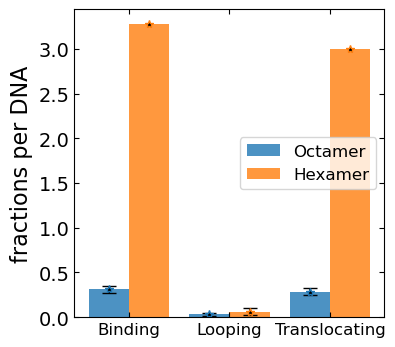

In [12]:
df_octamer_dna = pd.read_excel(excel_path_new, sheet_name='OctNse4Al647_NaCl (dna)')
df_octamer_dna = df_octamer_dna[df_octamer_dna['folderpath'].notna()]
df_octamer = df_octamer_dna[df_octamer_dna['folderpath'].str.contains(f'(20221221)')]

df_octamer_dna_kglu = pd.read_excel(excel_path_new, sheet_name='OctNse4Al647_KGlu (dna)')
df_octamer_dna_kglu = df_octamer_dna_kglu[df_octamer_dna_kglu['folderpath'].notna()]
df_octamer_glu = df_octamer_dna_kglu[df_octamer_dna_kglu['folderpath'].str.contains(f'(20221221)')]

results = calc_oct_hex_binding(df_hexamer=df_octamer_glu, df_octamer=df_octamer, plotting=True, norm_to_1=False)


error: [0.0424314       nan]


C:\Users\bipradha\AppData\Local\Temp\ipykernel_7392\2694886906.py:10: RuntimeWarning: invalid value encountered in sqrt
  fractions_err = norm * (1/total) * np.sqrt(total * fractions * (1 - fractions))


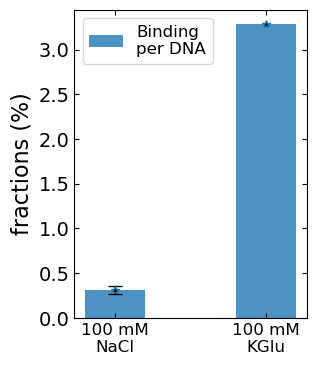

In [13]:
labels = ['100 mM\nNaCl', '100 mM\nKGlu']
values = [results['oct_binding'], results['hex_binding']]# hex here is KGlu
total = [results['oct_num_dna'], results['hex_num_dna']]
fig, ax = plt.subplots(figsize=(3,4))
ax = barstat_err_plot(labels, values, total, ax=ax, width=0.1, shift=0, norm=1, label='Binding\nper DNA')
plt.savefig(os.path.join(save_dir, 'OctBinding_KGluVsNaCl.svg'))

In [14]:
glu_binding = df_octamer_glu['#binding'].values
nacl_binding = df_octamer['#binding'].values
stats.ttest_ind(glu_binding, nacl_binding)

Ttest_indResult(statistic=14.194370718316577, pvalue=1.8100173304807216e-29)

In [15]:
print(results['oct_num_dna'], results['hex_num_dna'])

119 32


## Hexamer bleaching steps

error: [0.0860663  0.07302967 0.06206329]


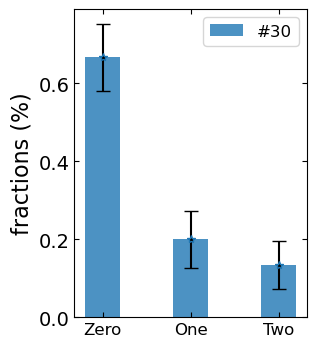

In [16]:
df_filt_temp = df_hexamer[df_hexamer['#BleachingStepLooping'].notna()]
two_steps = len(df_filt_temp[df_filt_temp['#BleachingStepLooping']==2])
one_steps = len(df_filt_temp[df_filt_temp['#BleachingStepLooping']==1])
zero_steps = len(df_filt_temp[df_filt_temp['#BleachingStepLooping']==0])

labels = ['Zero', 'One', 'Two']

values = [zero_steps, one_steps, two_steps]
total = two_steps + one_steps + zero_steps

ax = barstat_err_plot(labels, values, total, width=0.1, shift=0, norm=1, label=f'#{total}')


error: [0. 0.]


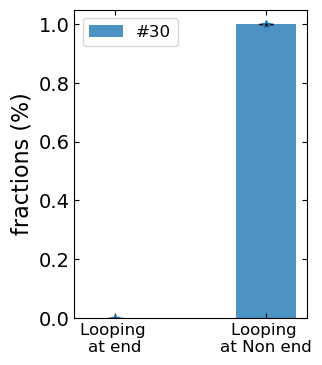

In [17]:
df_filt_temp_endLooping = df_filt_temp[df_filt_temp['loopingAtDnaEnd?']=='yes']
df_filt_temp_NonendLooping = df_filt_temp[df_filt_temp['loopingAtDnaEnd?']=='no']
labels = ['Looping \nat end', 'Looping \nat Non end']
values = [len(df_filt_temp_endLooping), len(df_filt_temp_NonendLooping)]
total = len(df_filt_temp_endLooping) + len(df_filt_temp_NonendLooping)
ax = barstat_err_plot(labels, values, total, width=0.1, shift=0, norm=1, label=f'#{total}')

## Hexamer Bleaching steps new

In [18]:
df_hexamer_new = pd.read_excel(excel_path_new, sheet_name='HexNse4Al647_NaCl')
df_hexamer_new = df_hexamer_new[df_hexamer_new['#BleachingStepLooping'].notna()]
df_hexamer_new = df_hexamer_new[:-47] # discarding the high power, bad gloxy experiments 

df_hexamer_KGlu = pd.read_excel(excel_path_new, sheet_name='HexNse4Al647_KGlu')
df_hexamer_KGlu = df_hexamer_KGlu[df_hexamer_KGlu['#BleachingStepLooping'].notna()]
df_hexamer_KGlu = df_hexamer_KGlu[30:100] # discarding the high power, bad gloxy experiments 

df_hexamers_merged = pd.concat([df_hexamer_new, df_hexamer_KGlu], ignore_index=True, sort=False)


error: [0.02275609 0.03737236 0.03810144 0.00998186]
error: [0.00286182 0.00493559 0.00499898 0.        ]


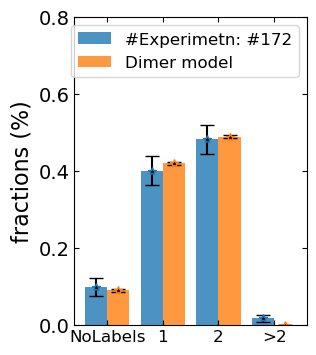

In [19]:

df_filt_temp = df_hexamers_merged
df_filt_temp = df_filt_temp.sample(frac=1)#.reset_index(drop=True)
two_steps = len(df_filt_temp[df_filt_temp['#BleachingStepLooping']==2])
one_steps = len(df_filt_temp[df_filt_temp['#BleachingStepLooping']==1])
zero_steps = len(df_filt_temp[df_filt_temp['#BleachingStepLooping']==0])
agg_steps = len(df_filt_temp[df_filt_temp['#BleachingStepLooping']==-1])
labels = ['NoLabels', '1', '2', '>2']

values = [zero_steps, one_steps, two_steps, agg_steps]
total = two_steps + one_steps + zero_steps + agg_steps

ax = barstat_err_plot(labels, values, total, width=0.1, shift=-0.05, norm=1, label=f'#Experimetn: #{total}')
fracion, fraction_err = error_calc(values, total=total, norm=1)

labelling_eficiency = 0.7
norm_tot = 10000
step_theory_2 = norm_tot*labelling_eficiency ** 2
step_theory_1 = norm_tot*2 * labelling_eficiency * (1-labelling_eficiency)
step_theory_0 = norm_tot*(1-labelling_eficiency) ** 2
step_theory_agg = 0
values = [step_theory_0, step_theory_1, step_theory_2, step_theory_agg]
frac_theory, fraction_err = error_calc(values, total=norm_tot, norm=1)
barstat_err_plot(labels, values, total=norm_tot, ax=ax, width=0.1, shift=0.05, norm=1, label='Dimer model')

ax.set_ylim(0, 0.8)
plt.savefig(os.path.join(save_dir, 'Hexamer_bleaching_steps.svg'))

In [20]:
p_values = stats.binomtest(two_steps, total, frac_theory[1], alternative='two-sided')
p_values

BinomTestResult(k=83, n=172, alternative='two-sided', proportion_estimate=0.48255813953488375, pvalue=0.10469439211832363)

In [21]:
frac_theory

array([0.09  , 0.42  , 0.4899, 0.    ])

In [22]:
n = int(len(df_filt_temp)/2)
a = df_filt_temp['#BleachingStepLooping'].values[:n]
b = df_filt_temp['#BleachingStepLooping'].values[n:]
stats.ttest_ind(a, b, equal_var=False)

Ttest_indResult(statistic=0.41692221202443297, pvalue=0.6772837092775738)

## Bleaching Steps: Nse2 labeled

error: [0.06288607 0.07143378 0.08111071 0.03622354]
error: [0.00286182 0.00493559 0.00499898 0.        ]


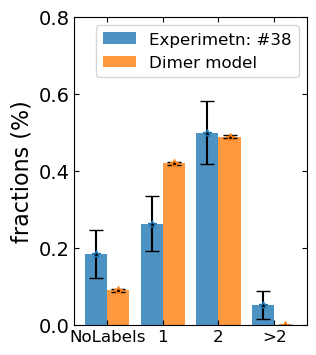

In [23]:
df_octamer_Nse2 = pd.read_excel(excel_path_new, sheet_name='OctNse2Al647_KGlu')# change the excel path
df_octamer_Nse2 = df_octamer_Nse2[df_octamer_Nse2['#BleachingStepLooping'].notna()]
df_filt_temp = df_octamer_Nse2

two_steps = len(df_filt_temp[df_filt_temp['#BleachingStepLooping']==2])
one_steps = len(df_filt_temp[df_filt_temp['#BleachingStepLooping']==1])
zero_steps = len(df_filt_temp[df_filt_temp['#BleachingStepLooping']==0])
agg_steps = len(df_filt_temp[df_filt_temp['#BleachingStepLooping']==-1])
labels = ['NoLabels', '1', '2', '>2']

values = [zero_steps, one_steps, two_steps, agg_steps]
total = two_steps + one_steps + zero_steps + agg_steps

ax = barstat_err_plot(labels, values, total, width=0.1, shift=-0.05, norm=1, label=f'Experimetn: #{total}')

labelling_eficiency = 0.7
norm_tot = 10000
step_theory_2 = norm_tot*labelling_eficiency ** 2
step_theory_1 = norm_tot*2 * labelling_eficiency * (1-labelling_eficiency)
step_theory_0 = norm_tot*(1-labelling_eficiency) ** 2
step_theory_agg = 0
values = [step_theory_0, step_theory_1, step_theory_2, step_theory_agg]
barstat_err_plot(labels, values, total=norm_tot, ax=ax, width=0.1, shift=0.05, norm=1, label='Dimer model')

ax.set_ylim(0, 0.8)
plt.savefig(os.path.join(save_dir, 'Nse2LabeledOct_bleaching_steps.svg'))

## Loop release time

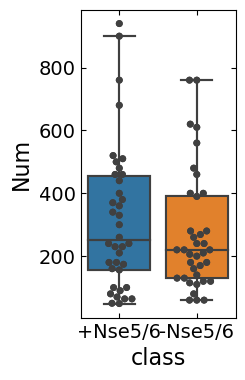

In [24]:
df_octamer_Nse2 = pd.read_excel(excel_path_new, sheet_name='OctNse2Al647_KGlu')# change the excel path
df_octamer_Nse2 = df_octamer_Nse2[df_octamer_Nse2['LoopDisruptionTime'].notna()]

df_hexamer_new = pd.read_excel(excel_path_new, sheet_name='HexNse4Al647_KGlu')
df_hexamer_new = df_hexamer_new[df_hexamer_new['LoopDisruptionTime'].notna()]

acq_time = 0.2 # seconcds
df_temp = pd.concat([pd.DataFrame({'Num': acq_time*df_octamer_Nse2['LoopDisruptionTime'], 'class': '+Nse5/6'}),
pd.DataFrame({'Num': acq_time*df_hexamer_new['LoopDisruptionTime'], 'class': '-Nse5/6'})])
# df_oct_highsalt['class_before'] = 1
fig, ax = plt.subplots(figsize=(2,4))
# sns.set(style="ticks")
sns.boxplot(x='class', y="Num", data=df_temp, showfliers = False, ax=ax)
sns.swarmplot(x='class', y="Num", data=df_temp, color=".25", ax=ax)


# df_oct_highsalt['class_highsalt'] = 2
sns.boxplot(x='class', y="Num", data=df_temp, showfliers = False, ax=ax)
sns.swarmplot(x='class', y="Num", data=df_temp, color=".25", ax=ax)
# ax.set_yscale('log')
plt.show()
fig.savefig(os.path.join(save_dir, 'LoopReleaseTime.svg'))

In [25]:
len(df_octamer_Nse2['LoopDisruptionTime'].values)
len(df_hexamer_new['LoopDisruptionTime'].values)


37

In [26]:
aquisition_time = 0.2 # seconds
print(aquisition_time*df_octamer_Nse2['LoopDisruptionTime'].std())

print(aquisition_time*df_hexamer_new['LoopDisruptionTime'].mean())


229.64989898194645
272.9675675675676


In [27]:
stats.ttest_ind(df_octamer_Nse2['LoopDisruptionTime'].values, df_hexamer_new['LoopDisruptionTime'].values, equal_var=False)

Ttest_indResult(statistic=0.9101513162542175, pvalue=0.3658115733942716)

## loop extrusion rates: Oct Vs Hex

In [28]:
excel_path_EK = '.\LoopwtSmc56.xlsx'
os.path.exists(excel_path_EK)
with pd.ExcelFile(excel_path_EK) as xls:
    print(xls.sheet_names)

['Figure 1k', 'Figure 1l', 'Figure 1m', 'Figure 4b']


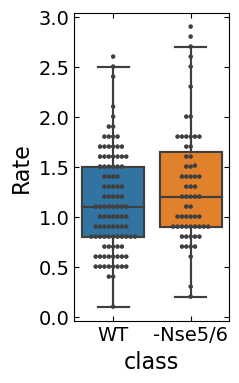

In [29]:
df_rates = pd.read_excel(excel_path_EK, sheet_name='Figure 4b', skiprows=1)
df_temp = pd.concat([pd.DataFrame({'Rate': df_rates['WT'], 'class': 'WT'}),
pd.DataFrame({'Rate': df_rates['Hex'], 'class': '-Nse5/6'})])

fig, ax = plt.subplots(figsize=(2,4))
# sns.set(style="ticks")
sns.boxplot(x='class', y="Rate", data=df_temp, showfliers = False, ax=ax)
sns.swarmplot(x='class', y="Rate", data=df_temp, color=".25", size=3, ax=ax)


# df_oct_highsalt['class_highsalt'] = 2
sns.boxplot(x='class', y="Rate", data=df_temp, showfliers = False, ax=ax)
sns.swarmplot(x='class', y="Rate", data=df_temp, color=".25", size=3, ax=ax)
# ax.set_yscale('log')
plt.show()
fig.savefig(os.path.join(save_dir, 'LoopRatesWtVsHex.svg'))

In [30]:
stats.ttest_ind(df_rates['WT'].dropna().values, df_rates['Hex'].dropna().values, equal_var=True)

Ttest_indResult(statistic=-2.0508834902335797, pvalue=0.04187922163605981)

## Hexamer + Nse5/6

error: [0.04430585 0.01368912]


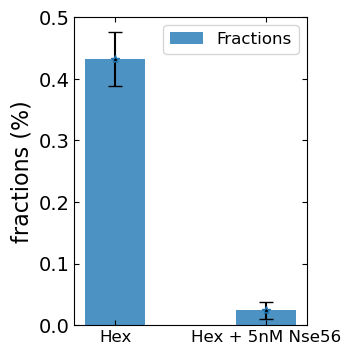

In [31]:
labels = ['Zero', 'One', 'Two']

loops_hex = 54
loops_hex_plus_Nse56 = 3
total = 125
values = [loops_hex, loops_hex_plus_Nse56]
labels = ["Hex", "Hex + 5nM Nse56"]
ax = barstat_err_plot(labels, values, total, width=0.1, shift=0, norm=1)
plt.savefig(os.path.join(save_dir, 'HexPlusnse56.svg'))

In [32]:
stats.binomtest(loops_hex_plus_Nse56, total, loops_hex/total)

BinomTestResult(k=3, n=125, alternative='two-sided', proportion_estimate=0.024, pvalue=4.539148801278545e-26)

### Loop release by Nse5/6

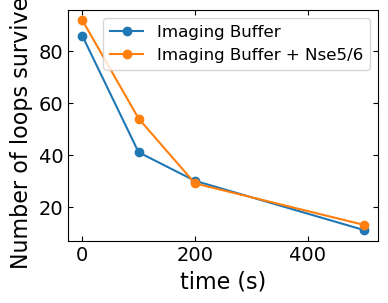

In [33]:
df_hexamer_Nse56 = pd.read_excel(excel_path_new, sheet_name='Nse56flow')
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(0.1*df_hexamer_Nse56['frameNumber'], df_hexamer_Nse56['#loopsBuffer'], '-o', label='Imaging Buffer')
plt.plot(0.1*df_hexamer_Nse56['frameNumber'], df_hexamer_Nse56['#loops10nMNse56'], '-o', label='Imaging Buffer + Nse5/6')
plt.xlabel('time (s)')
plt.ylabel('Number of loops survived')
plt.legend()
plt.savefig(os.path.join(save_dir, 'LoopReleaseByNse56.svg'))

## Effect of Pottassium Glutamate

error: [0.05315141 0.02774309 0.05315141]


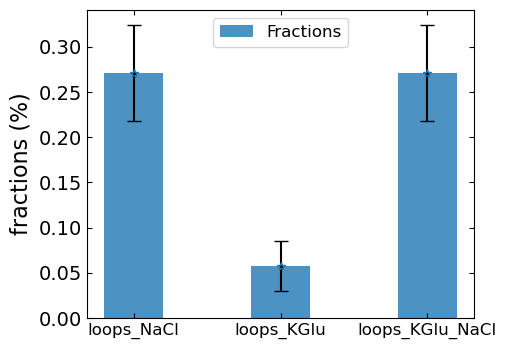

In [34]:
#Octamer: Smc5/6 Nse4SnapAlexa647
labels = ['100mM NaCl', '100mM KGlu', '100mM KGlu + 50mM NaCl']

loops_NaCl = 19
loops_KGlu = 4
loops_KGlu_NaCl = 19
total = 70
values = [loops_NaCl, loops_KGlu, loops_KGlu_NaCl]
labels = ["loops_NaCl", "loops_KGlu", "loops_KGlu_NaCl"]

fig, ax = plt.subplots(figsize=(5,4))
ax = barstat_err_plot(labels, values, total, width=0.1, shift=0, norm=1, ax=ax)
plt.savefig(os.path.join(save_dir, 'OctamerKGluNaCl.svg'))

error: [0.02932286 0.01555485]


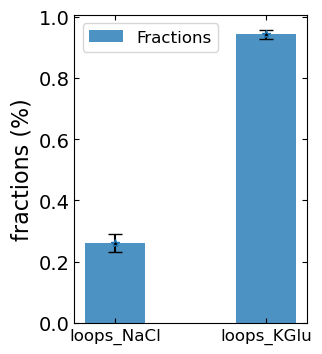

In [35]:
#Hexamer: Smc5/6 (Unlabeled)
labels = ['100mM NaCl', '120mM KGlu']

loops_NaCl = 59
loops_KGlu = 212
total = 225
values = [loops_NaCl, loops_KGlu]
labels = ["loops_NaCl", "loops_KGlu"]

fig, ax = plt.subplots(figsize=(3,4))
ax = barstat_err_plot(labels, values, total, width=0.1, shift=0, norm=1, ax=ax)
plt.savefig(os.path.join(save_dir, 'hexamerKGluNaCl.svg'))

## Highsalt wash

In [36]:
df_oct_highsalt = pd.read_excel(excel_path_new, sheet_name='Nse2Al647HighSalt')
df_oct_highsalt.head()

,Name,#Smc56,#Smc56HighSalt,#Smc56HighSalt100mM,ActivityHighSalt,ActivityLowSalt,comments,path
0,dna (19),32,1,1,diffusive,diffusive,20221118_CH1_4nMOctNse2SnapAl647_KGlu_20mW_New...,20221118_CH1_2nMOctNse2SnapAl647_KGlu_20mW_New...
1,dna,26,2,0,diffusive,none,NaN,NaN
2,dna (2),35,4,2,diffusive,diffusive,NaN,NaN
3,dna (3),21,3,2,diffusive,translocating,NaN,NaN
4,dna (4),22,3,3,diffusive,diffusive,NaN,NaN


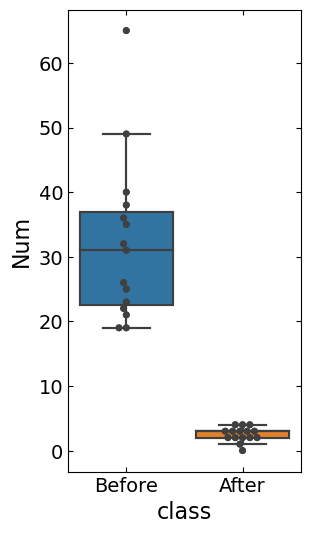

In [37]:
df_temp = pd.concat([pd.DataFrame({'Num': df_oct_highsalt['#Smc56'], 'class': 'Before'}),
pd.DataFrame({'Num': df_oct_highsalt['#Smc56HighSalt'], 'class': 'After'})])
# df_oct_highsalt['class_before'] = 1
fig, ax = plt.subplots(figsize=(3,6))
# sns.set(style="ticks")
sns.boxplot(x='class', y="Num", data=df_temp, showfliers = False, ax=ax)
sns.swarmplot(x='class', y="Num", data=df_temp, color=".25", ax=ax)


# df_oct_highsalt['class_highsalt'] = 2
sns.boxplot(x='class', y="Num", data=df_temp, showfliers = False, ax=ax)
sns.swarmplot(x='class', y="Num", data=df_temp, color=".25", ax=ax)
# ax.set_yscale('log')
plt.show()
fig.savefig(os.path.join(save_dir, 'BeforeAndAfterHighSalt_survival.svg'))